# Calibrate HD network to produce different bump shapes

The network has 8 E neurons and 8 I neurons arranged around a ring with the following connectivity:
* EE connectivity depends on the closest distance between pairs of E neurons around the ring
  * With a ring of 8 neurons, the distance is either 0 (self-recurrent), 1, 2, 3, or 4. The weight for each distance is set independently but is the same for the whole ring, so it's symmetrical. These parameters are `dist0` to `dist4`
* EI connectivity is all to all, with a constant weight - `weight_ei`
* II connectivity is all to all, with a constant weight - `weight_ii`
* IE connectivity is one to one, with a constant weight - `weight_ie`

Optimisation of the network can also change the input weight `weight_input` and the time constant of the excitatory synapses for the E neurons - `tau_syn_e_exc`.

The network is provided some Poisson input for 100 ms, then is allowed to run for 300 ms without input to see whether a stable bump is maintained. How well the activity bump in the final 300 ms fits to one of predefined shapes (RMS error) provides the objective function for optimisation. The three bump shapes are (all with a peak firing rate of 60 Hz):
* a Gaussian with standard deviation of 1
* a sinusoidal bump with width of 6 neurons (from $-\pi$ to $\pi$)
* a triangular bump

CMA evolutionary strategy is used to optimise the bump shape of the network for each of these three cases. The performance is then shown and the EE connectivity kernel visualised. For all three cases the optimisation is stopped once a "reasonably good" solution is found to reduce computational load.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
import attractor_network
import cma
from typing import Callable, Any, List, Tuple

plt.style.use('seaborn-v0_8-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

INFO       Cache size for target 'cython': 1663153530 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\Dominic\.cython\brian_extensions' directory. [brian2]


In [3]:
warm_up_duration = 100*b2.ms
duration = 400*b2.ms
network = attractor_network.AttractorNetwork()

In [4]:
def run_network(network: attractor_network.AttractorNetwork, params: dict, warm_up_duration=warm_up_duration, duration=duration):
	network_params = {name : value for name,value in params.items() if not name.startswith('dist')}
	ee_connectivity_profile = np.array([value for name,value in params.items() if name.startswith('dist')])
	
	network.reset()
	network.params.update(network_params)
	network.circular_distance_EE_connectivity(ee_connectivity_profile)
	network.run_with_inputs(warm_up_duration, [200*b2.Hz if 3<=i<=5 else 20*b2.Hz for i in range(network.num_excitatory)])
	network.run_with_inputs(duration, [20*b2.Hz if 3<=i<=5 else 0*b2.Hz for i in range(network.num_excitatory)])

def get_network_results(network: attractor_network.AttractorNetwork, loss: Callable[[np.ndarray,np.ndarray,np.ndarray],Tuple[np.ndarray,float]]):
	response_start = network.monitor_e.i[:][np.logical_and(warm_up_duration<= network.monitor_e.t, network.monitor_e.t < warm_up_duration+duration/2)]
	response_end = network.monitor_e.i[:][network.monitor_e.t >= warm_up_duration+duration/2]
	indices_start, counts_start = np.unique(response_start, return_counts=True)
	indices_end, counts_end = np.unique(response_end, return_counts=True)
	full_indices_start, full_rates_start = hist_counts_to_full(indices_start, counts_start/(duration/2), np.arange(network.num_excitatory))
	full_indices_end, full_rates_end = hist_counts_to_full(indices_end, counts_end/(duration/2), np.arange(network.num_excitatory))
	best_fit, rms = loss(full_indices_start, full_rates_start, full_rates_end)
	return full_indices_start, full_rates_start, full_rates_end, best_fit, rms

def hist_counts_to_full(indices, counts, full_range):
	full_counts = np.zeros_like(full_range)
	full_counts[indices] = counts
	return full_range, full_counts

def gaussian(x, mean, stdev, scaled=True):
	return np.exp(-1/2* ((x-mean)/stdev)**2) * (1/(stdev*np.sqrt(2*np.pi)) if scaled else 1)

def circ_wrapped_distance(x:np.ndarray, wrapping_boundary:float=2*np.pi):
	return wrapping_boundary/2 - np.abs(np.abs(x) - wrapping_boundary/2)

def circ_gaussian(x, mean, stdev, scaled=True) -> np.ndarray:
	wrapped_distance = circ_wrapped_distance(x-mean, x.shape[0])
	return np.exp(-1/2* (wrapped_distance/stdev)**2) * (1/(stdev*np.sqrt(2*np.pi)) if scaled else 1)

def circ_triangle(x:np.ndarray, mean):
	negative_wrapped_distance = x.shape[0]/2 - circ_wrapped_distance(x-mean, x.shape[0])
	return negative_wrapped_distance / (x.shape[0]/2)

def circ_sin(x:np.ndarray, mean, width=270):
	distance = 2*np.pi/x.shape[0] * (360/width) * circ_wrapped_distance(x-mean, x.shape[0])
	sin = 1/2*(1 + np.cos(distance))
	sin[abs(distance) > np.pi] = 0
	return sin

def response_rms_error(indices, rates, target):
	full_rates = np.zeros_like(target)
	full_rates[indices] = rates
	return np.sqrt(np.mean((full_rates - target)**2))

def get_rms_and_best(target_rates, rates1, rates2):
	rms = np.sqrt((np.mean((target_rates - np.atleast_2d(rates1).T)**2, axis=0)) + np.mean((target_rates - np.atleast_2d(rates2).T)**2, axis=0)/2)
	best_index = np.argmin(rms)
	return target_rates[:,best_index], rms[best_index]

def get_best_gaussian_rms(indices, rates1, rates2, peak=100, stdev=1): # don't go higher than 100 for this
	mean_range = np.atleast_2d(np.arange(0, len(indices), 0.01))
	gaussian_rates = peak * circ_gaussian(np.tile(np.atleast_2d(indices).T, (1,len(mean_range))), mean_range, stdev, False)
	return get_rms_and_best(gaussian_rates, rates1, rates2)

def get_best_sinusoid_rms(indices, rates1, rates2, peak=100, width=270):
	mean_range = np.atleast_2d(np.arange(0, len(indices), 0.01))
	sinusoid_rates = peak * circ_sin(np.tile(np.atleast_2d(indices).T, (1,len(mean_range))), mean_range, width)
	return get_rms_and_best(sinusoid_rates, rates1, rates2)

def get_best_triangle_rms(indices, rates1, rates2, peak=100):
	mean_range = np.atleast_2d(np.arange(0, len(indices), 0.01))
	triangle_rates = peak * circ_triangle(np.tile(np.atleast_2d(indices).T, (1,len(mean_range))), mean_range)
	return get_rms_and_best(triangle_rates, rates1, rates2)

def windowed_spike_rates(times, indices, duration:int, max_index: int, window_size:int):
	# split the indices array based on the times, with bins depending on window_size
	indices_bins = np.split(indices, np.sum(np.atleast_2d(times) < np.atleast_2d(np.arange(window_size,duration,window_size)).T, axis=1))
	means_peaks_angles =np.array([bump_population_vector_readout(hist_counts_to_full(*np.unique(indices_array, return_counts=True), np.arange(network.num_excitatory))[1]) for indices_array in indices_bins])
	return means_peaks_angles[:,0], means_peaks_angles[:,1], means_peaks_angles[:,2]

def bump_population_vector_readout(rates):
	"""Takes the firing rates for each neuron, distributed around a circle and calculates the mean angle and standard deviation."""
	angles = np.linspace(0, 2*np.pi, len(rates)+1)[:-1]
	mean_x = np.mean(rates*np.cos(angles))
	mean_y = np.mean(rates*np.sin(angles))
	mean_angle = np.arctan2(mean_y, mean_x)
	peak = np.sqrt(mean_x**2 + mean_y**2)
	# treat each spike as a sample
	standard_deviation = np.sqrt(np.sum(rates*circ_wrapped_distance(angles-mean_angle)**2) / np.sum(rates))
	return mean_angle, peak, standard_deviation

def plot_response(network, loss):
	indices, rates_start, rates_end, best_fit, rms = get_network_results(network, loss)
	# pop_mean, pop_peak, pop_stddev = bump_population_vector_readout(rates)
	window_duration=100
	means, _, angles = windowed_spike_rates(network.monitor_e.t/b2.ms, network.monitor_e.i[:], int((warm_up_duration+duration)/b2.ms), network.num_inhibitory, window_duration)
	neuron_means = (means % (2*np.pi))/2/np.pi*network.num_excitatory
	neuron_angles = angles/2/np.pi*network.num_excitatory

	fig, axs = plt.subplot_mosaic('AD;BD;CD', figsize=(8,5), width_ratios=[2,1])
	axs = np.array([axs[key] for key in sorted(axs.keys())])
	axs[0].sharex(axs[2])
	axs[1].sharex(axs[2])
	axs[0].sharey(axs[2])
	axs[1].sharey(axs[2])
	axs[0].tick_params(labelbottom=False)
	axs[1].tick_params(labelbottom=False)
	assert(isinstance(axs, np.ndarray))
	axs[0].plot(network.monitor_e.t/b2.ms, network.monitor_e.i[:], '.b')
	popvec_time = window_duration/2+np.arange(0,int((warm_up_duration+duration)/b2.ms),window_duration)
	axs[0].fill_between(popvec_time, neuron_means-neuron_angles, neuron_means+neuron_angles, alpha=0.2, color='lime')
	axs[0].set_ylabel('Neuron index')
	axs[0].set_ylim([-0.5,network.num_excitatory])
	axs[0].set_title('E spikes')
	axs[1].plot(network.monitor_i.t/b2.ms, network.monitor_i.i[:], '.r')
	axs[1].set_ylabel('Neuron index')
	axs[1].set_title('I spikes')
	axs[2].plot(network.monitor_input.t/b2.ms, network.monitor_input.i[:], '.k')
	axs[2].set_xlabel('Time (ms)')
	axs[2].set_ylabel('Neuron index')
	axs[2].set_title('Input spikes')

	axs[3].set_title('Self-sustained spike rates')
	axs[3].set_xlabel('Neuron index')
	axs[3].set_ylabel('Firing Rate (Hz)')
	# axs[3].set_xlim([0,network.num_excitatory-1])
	max_y_value = max([rates_start.max(), rates_end.max(), best_fit.max()])
	axs[3].set_ylim([0,max_y_value*1.3])
	axs[3].bar(indices, rates_start, align='edge', width=-0.3, label='Actual firing first half')
	axs[3].bar(indices, rates_end, align='edge', width=0.3, label='Actual firing second half')
	axs[3].plot(np.arange(network.num_excitatory), best_fit, 'k.-', label='Target firing')
	axs[3].legend(loc='upper center')
	# axs[3].plot(pop_peak*circ_gaussian(indices, pop_mean*network.num_excitatory/2/np.pi, pop_stddev*network.num_excitatory/2/np.pi, False), 'r')
	axs[3].set_title(f'Self-sustained spike rates\nerror={rms:.3f}')
	plt.tight_layout()

params_to_tune = {
	'dist0': (0,20,20, 1),
	'dist1': (0,20,5, 1),
	'dist2': (0,20,2, 1),
	'dist3': (0,20,1, 1),
	'dist4': (0,20,0, 1),
	'weight_ei': (0, 20, 15, 1),
	'weight_ie': (0, 100, 85, 1),
	'weight_ii': (0, 5, 5, 1),
}

def run_get_loss(params, loss):
	params_dict = {name : value*unit for (name, (_,_,_,unit)),value in zip(params_to_tune.items(), params)}
	run_network(network, params_dict)
	_, _, _, _, error = get_network_results(network, loss)

	return error

x0 = [p[2] for p in params_to_tune.values()]
bounds = [p[:2] for p in params_to_tune.values()]

# return function that takes a value between 0 and 1 and outputs a value in the range
param_scaler = lambda min,max : lambda x: min+x*(max-min)
param_scaler_nonnegative = lambda min,max : lambda x: min+x**2*(max-min)
param_unscaler_nonnegative = lambda min,max : lambda x: np.sqrt((x-min)/(max-min))

param_scalers = [param_scaler_nonnegative(*bound) for bound in bounds]
param_unscalers = [param_unscaler_nonnegative(*bound) for bound in bounds]

scale_params = lambda x: [scaler(param) for scaler,param in zip(param_scalers, x)]
unscale_params = lambda x: [scaler(param) for scaler,param in zip(param_unscalers, x)]

# return a function that wraps run_get_loss, so that CMA can learn params in the range 0-1 but these are 
# transformed to the ranges we want for the simulation
# returns a function that takes x, calls run_get_loss(transform_params(x))
def simulation_param_wrapper(loss):
	return lambda x: run_get_loss(scale_params(x), loss)

## Gaussian Bump

In [5]:
x_best_gaussian, cma_results = cma.fmin2(simulation_param_wrapper(get_best_gaussian_rms), [0.5]*len(x0), 0.2, options={'ftarget': 5, 'maxfevals': 1000, 'popsize': 20})

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 8 (seed=976405, Mon Sep  4 19:32:28 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 3.748241547282711e+01 1.0e+00 2.22e-01  2e-01  2e-01 3:26.7
    2     40 3.812387398769008e+01 1.3e+00 2.91e-01  3e-01  3e-01 4:07.4
    3     60 2.360629552422180e+01 1.6e+00 3.21e-01  3e-01  4e-01 4:41.0
    4     80 2.018313123657503e+01 1.6e+00 3.57e-01  3e-01  4e-01 5:07.7
    5    100 3.904535147926040e+01 1.8e+00 3.98e-01  3e-01  4e-01 5:36.7
    6    120 1.654990520065815e+01 2.1e+00 3.90e-01  3e-01  4e-01 6:08.8
    7    140 3.250803184676010e+01 2.1e+00 4.18e-01  4e-01  5e-01 6:36.6
    8    160 3.419305874382034e+01 2.4e+00 4.04e-01  4e-01  5e-01 7:02.6
    9    180 3.227917805419195e+01 2.5e+00 4.75e-01  4e-01  6e-01 7:29.3
   10    200 3.360592858827007e+01 2.7e+00 4.91e-01  4e-01  6e-01 7:53.7
   11    220 3.318937154474776e+01 2.8e+00 4.70e-01  4e-01  6e-01 8:18.2
   12    240 2.978305067245969e+0

In [6]:
params_gaussian = {name : value*unit for (name, (_,_,_,unit)),value in zip(params_to_tune.items(), scale_params(x_best_gaussian))}
run_network(network, params_gaussian)

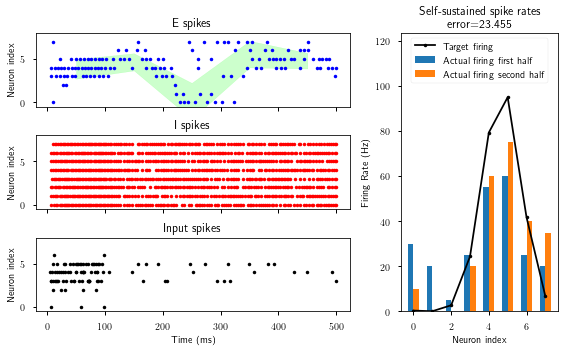

In [7]:
plot_response(network, get_best_gaussian_rms)
plt.savefig('plots/calibrated-gaussian.pdf')

In [8]:
params_gaussian

{'dist0': 7.98467095690836,
 'dist1': 25.498717706982546,
 'dist2': 0.13223586695122624,
 'dist3': 0.014749402172760242,
 'dist4': 10.94953317973927,
 'weight_ei': 18.864724221308922,
 'weight_ie': 181.62694837792026,
 'weight_ii': 15.320662834213453}

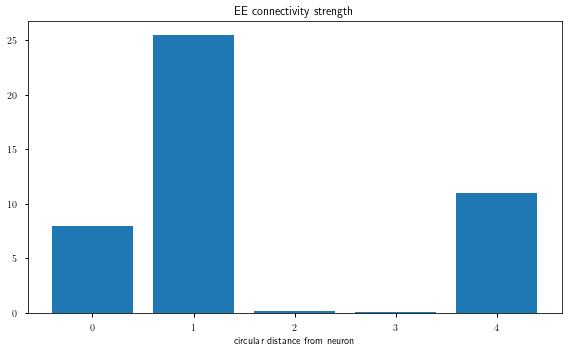

In [9]:
kernel_gaussian = [value for name, value in params_gaussian.items() if name.startswith('dist')]
plt.figure(figsize=(8,5))
plt.bar(range(len(kernel_gaussian)), kernel_gaussian)
plt.xlabel('circular distance from neuron')
plt.title('EE connectivity strength')
plt.tight_layout()
plt.show()

The optimisation found a solution with strong EE self-recurrence and to the nearest neighbours, but with almost no other excitation. This results in a bump with predominantly 2 neurons firing which roughly matches the desired Gaussian shape

## Sinusoidal bump

In [10]:
x_best_sin, cma_results = cma.fmin2(simulation_param_wrapper(get_best_sinusoid_rms), [0.5]*len(x0), 0.2, options={'ftarget': 5, 'maxfevals': 1000, 'popsize': 20})

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 8 (seed=964645, Mon Sep  4 19:57:40 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 2.888846281997281e+01 1.0e+00 2.05e-01  2e-01  2e-01 0:24.4
    2     40 1.720966953835750e+01 1.3e+00 2.39e-01  2e-01  3e-01 0:49.3
    3     60 2.657655139091824e+01 1.5e+00 2.88e-01  3e-01  3e-01 1:13.9
    4     80 2.718249946595483e+01 1.8e+00 3.70e-01  3e-01  4e-01 1:38.9
    5    100 1.946762442380257e+01 2.0e+00 3.73e-01  3e-01  4e-01 2:05.1
    6    120 1.971899351946224e+01 2.2e+00 3.54e-01  3e-01  4e-01 2:37.5
    7    140 1.688157756679351e+01 2.3e+00 3.44e-01  3e-01  4e-01 3:02.2
    8    160 1.794811428820286e+01 2.4e+00 3.47e-01  2e-01  4e-01 3:26.8
    9    180 1.502693501642369e+01 2.5e+00 3.66e-01  2e-01  4e-01 3:52.7
   10    200 1.834485716437124e+01 2.8e+00 3.48e-01  2e-01  4e-01 4:17.6
   11    220 1.414487648460894e+01 2.8e+00 2.80e-01  2e-01  3e-01 4:43.9
   12    240 6.866168018759891e+0

In [11]:
params_sin = {name : value*unit for (name, (_,_,_,unit)),value in zip(params_to_tune.items(), scale_params(x_best_sin))}
run_network(network, params_sin)

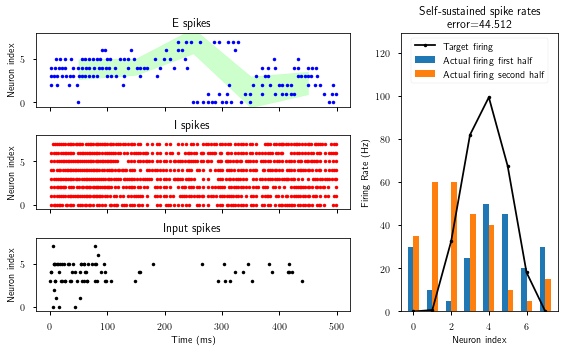

In [12]:
plot_response(network, get_best_sinusoid_rms)
plt.savefig('plots/calibrated-sin.pdf')

In [13]:
params_sin

{'dist0': 6.2765817956546845,
 'dist1': 19.66264731214118,
 'dist2': 0.033028203671932536,
 'dist3': 0.040867283724666456,
 'dist4': 0.10979072470477519,
 'weight_ei': 8.216516811500089,
 'weight_ie': 197.41890199928883,
 'weight_ii': 9.296526020691813}

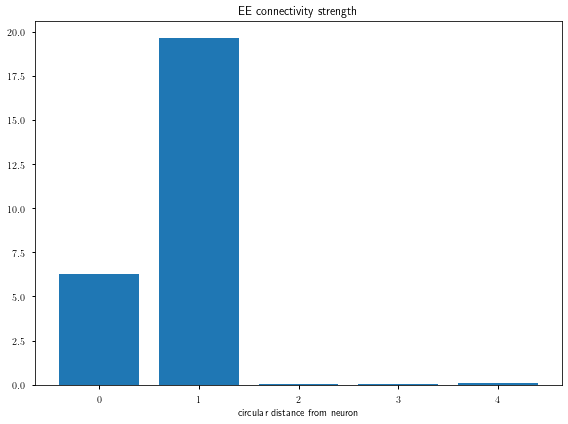

In [14]:
kernel_sin = [value for name, value in params_sin.items() if name.startswith('dist')]
plt.figure()
plt.bar(range(len(kernel_sin)), kernel_sin)
plt.xlabel('circular distance from neuron')
plt.title('EE connectivity strength')
plt.tight_layout()
plt.show()

The solution for a sinusoidal bump has a very strong EE connection from neurons to their next neighbour. This results in activity patterns "zig-zagging" through the ring (eg. 3-4-5-6-5-6-5-4), which on average produce a sinusoidal bump. This doesn't seem like a very stable solution though.

For a longer simulation duration, we see that this isn't very stable and the bump tends to exhibit some random drift.

In [15]:
run_network(network, params_sin, duration=1000*b2.ms)

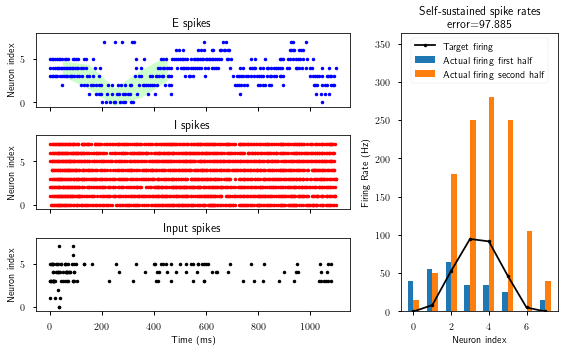

In [16]:
plot_response(network, get_best_sinusoid_rms)
plt.savefig('plots/calibrated-sin-long.pdf')

## Triangular bump

In [17]:
x_best_triangular, cma_results = cma.fmin2(simulation_param_wrapper(get_best_triangle_rms), [0.5]*len(x0), 0.25, options={'ftarget': 5, 'maxfevals': 1000, 'popsize': 20})


(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 8 (seed=899330, Mon Sep  4 20:10:35 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 3.265922534292569e+01 1.0e+00 2.89e-01  3e-01  3e-01 0:23.5
    2     40 4.322253463183296e+01 1.3e+00 3.55e-01  3e-01  4e-01 0:48.4
    3     60 3.544009029333870e+01 1.3e+00 3.35e-01  3e-01  3e-01 1:11.2
    4     80 3.533235061526476e+01 1.3e+00 3.22e-01  3e-01  3e-01 1:34.9
    5    100 3.238778705005947e+01 1.5e+00 3.05e-01  3e-01  3e-01 1:59.5
    6    120 1.739432378679896e+01 1.5e+00 3.02e-01  2e-01  3e-01 2:22.3
    7    140 2.588918693199924e+01 1.6e+00 2.70e-01  2e-01  3e-01 2:46.7
    8    160 2.243044805615795e+01 1.7e+00 2.71e-01  2e-01  3e-01 3:12.0
    9    180 1.749285568453590e+01 2.1e+00 2.31e-01  2e-01  2e-01 3:34.5
   10    200 2.660357118884606e+01 2.1e+00 1.98e-01  1e-01  2e-01 3:57.4
   11    220 1.948396776839871e+01 2.3e+00 1.72e-01  1e-01  2e-01 4:20.5
   12    240 1.333697866834914e+0

In [18]:
params_triangle = {name : value*unit for (name, (_,_,_,unit)),value in zip(params_to_tune.items(), scale_params(x_best_triangular))}
run_network(network, params_triangle)

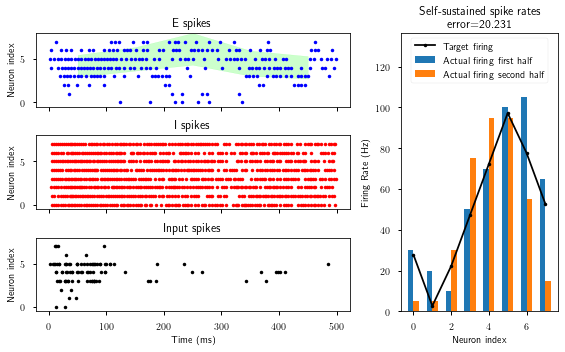

In [19]:
plot_response(network, get_best_triangle_rms)
plt.savefig('plots/calibrated-triangle.pdf')

In [20]:
params_triangle

{'dist0': 0.12912297551052193,
 'dist1': 16.316372939940887,
 'dist2': 2.510363140498554,
 'dist3': 1.4476235858219306,
 'dist4': 0.260414262483373,
 'weight_ei': 6.980726844354449,
 'weight_ie': 150.35183693241444,
 'weight_ii': 10.79874243693768}

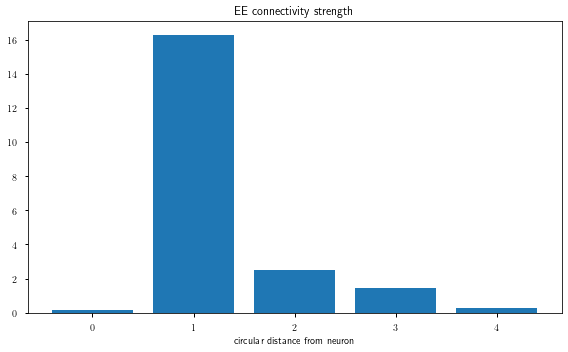

In [21]:
kernel_triangle = [value for name, value in params_triangle.items() if name.startswith('dist')]
plt.figure(figsize=(8,5))
plt.bar(range(len(kernel_triangle)), kernel_triangle)
plt.xlabel('circular distance from neuron')
plt.title('EE connectivity strength')
plt.tight_layout()
plt.show()

Like for the sinusoidal case, for the triangular bump a solution is found with very high EE connection strength to the next nearest neighbour. This results in an unstable bump that on average has triangular shaped activity

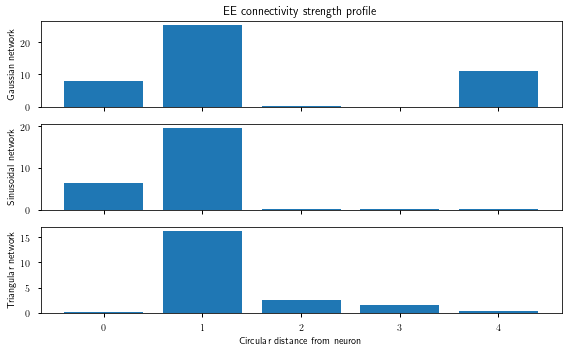

In [29]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=(8,5))
axs[0].bar(range(len(kernel_gaussian)), kernel_gaussian)
axs[1].bar(range(len(kernel_sin)), kernel_sin)
axs[2].bar(range(len(kernel_triangle)), kernel_triangle)
axs[2].set_xlabel('Circular distance from neuron')
axs[0].set_title('EE connectivity strength profile')
axs[0].set_ylabel('Gaussian network')
axs[1].set_ylabel('Sinusoidal network')
axs[2].set_ylabel('Triangular network')
plt.tight_layout()
plt.savefig('plots/calibrated-kernels.pdf')
plt.show()